## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [1]:
#!pip install scattertext
#!pip install wordcloud
#!pip install textblob
#!pip install spacy
#!python -m spacy download en_core_web_sm

In [2]:
# load libraries
# ----------
import pandas as pd
import numpy as np
from PIL import Image
import spacy
import en_core_web_sm
import scattertext as st
nlp = en_core_web_sm.load()
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import seaborn as sns
import matplotlib.pyplot as plt


# code for kMeans and silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

# settings 
%matplotlib inline


In [3]:

import string
import re

In [4]:
# load data 
# ----------
congress_tweets = pd.read_csv("data/116th Congressional Tweets and Demographics.csv")
# fill in this line of code with a sufficient number of tweets, depending on your computational resources
np.random.seed(369)
congress_tweets = congress_tweets.sample(2000)
pd.set_option('display.max_colwidth', 2000)

congress_tweets.head()


tweet_id   screen_name                   datetime  \
936437  1.187430e+18  RepGwenMoore  2019-10-24T13:57:14-04:00   
101552  1.205240e+18   RepRoKhanna  2019-12-12T16:33:00-05:00   
290630  1.216890e+18   RodneyDavis  2020-01-13T19:52:44-05:00   
280629  1.141100e+18      RepCheri  2019-06-18T18:00:36-04:00   
812427  1.257780e+18  RepPeteOlson  2020-05-05T17:06:55-04:00   

                                                                                                                                                                                                                                                                                                                                                                    text  \
936437  Trump's #gagrule is causing real harm. Not only does this policy jeopardize low-income women’s access to cancer screenings and reproductive care, but the lack of funding could result in higher costs for patients. The ripple effects endanger women. https://www.nbcnews.com/news/latino/nearly-900-women-s-health-clinics-have-lost-federal-funding-n1069591   
101552                                                                          Wondering how we are going to pay for #MedicareForAll? Questions about how to keep your doctor, or what zero copay and zero premiums will mean for you? Join me tomorrow at 10am EST for a livestream with policy experts to discuss what the future of American health care looks like.   
290630                                     According to a 2018 report from the Equal Employment Opportunity Commission (EEOC), “women, especially older women, but also those at middle age, were subjected to more age discrimination than older men.” I offered an amendment to study this impact. https://www.youtube.com/watch?v=CK2d6qfYfAo&feature=youtu.be&t=4608   
280629     Had a great conversation about improving rural health care with @UICnursing in the Quad-Cities yesterday. Bringing down the cost of health care will remain a top priority of mine. Learn more in the @Dispatch_Argus: \n \nhttps://qconline.com/news/local/there-s-a-huge-need-nurses-talk-about-work-in/article_40ee6f12-765f-5686-9a75-5abf893f1560.html#1   
812427                                                                                                              Mental health is extremely important in these challenging times. @NAMIGulfCoast is making sure the people of #BrazoriaCounty know no one is alone. Another terrific example of #TX22GoodWillCreators! http://pbs.twimg.com/media/EXSGVH5WkAAOOgo.jpg   

       name_wikipedia position joined_congress_date    birthday gender state  \
936437     Gwen Moore      Rep             3-Jan-05   4/18/1951      F    WI   
101552      Ro Khanna      Rep             3-Jan-17   9/13/1976      M    CA   
290630   Rodney Davis      Rep             3-Jan-13    1/5/1970      M    IL   
280629   Cheri Bustos      Rep             3-Jan-13  10/17/1961      F    IL   
812427     Pete Olson      Rep             3-Jan-09   12/9/1962      M    TX   

       district_number       party trump_2016_state_share  \
936437               4    Democrat              1,405,284   
101552              17    Democrat              4,483,814   
290630              13  Republican              2,146,015   
280629              17    Democrat              2,146,015   
812427              22  Republican              4,685,047   

       clinton_2016_state_share obama_2012_state_share romney_2012_state_share  
936437                1,382,536              1,620,985               1,407,966  
101552                8,753,792              7,854,285               4,839,958  
290630                3,090,729              3,019,512               2,135,216  
280629                3,090,729              3,019,512               2,135,216  
812427                3,877,868              3,308,124               4,569,843

In [5]:
text = congress_tweets['text']

## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [6]:
# initalize an empty list
tokens_reduced = []
nlp = spacy.load('en_core_web_sm')

def rem_punc_stop(text):
    stop_words = STOP_WORDS
    
    punc = set(punctuation)
    
    #I am going to put everything in lowercases to be sure I caught stop words with upper letters. The risk might be loosing context, for instance Congress or emphasis, but that might not be important in my later model 
    punc_free = "".join([ch for ch in text if ch not in punc])
    
     # Remove emojis 
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    punc_free = emoji_pattern.sub(r'', punc_free)
   
    
    doc = nlp(punc_free)
    
    spacy_words = [token.text for token in doc]
    
    spacy_words = [token.text for token in doc if not token.like_num]
    
    spacy_words = [word for word in spacy_words if not word.startswith('http')]
    
    no_punc = [word for word in spacy_words if word not in stop_words]
    
     # I will clean the data further, to elimitate repetitive useless terms or text modifiers: RT, QT, and \n , wierdly the punctuation function is not working correctly to remove some signs
    no_punc = [word for word in no_punc if word not in ["RT", "QT", "amp", "\n", "\n\n", "\n \n", "#",  "." , "-", ",", ";", "?", "!",":", "'","~"]]
    
    return no_punc

In [7]:
# Create a new column with clean data
congress_tweets['clean_text'] = congress_tweets['text'].apply(rem_punc_stop)

# Reorder columns
cols = congress_tweets.columns.tolist()
cols.insert(cols.index('text') + 1, cols.pop(cols.index('clean_text')))
congress_tweets = congress_tweets.reindex(columns=cols)

# Display dataframe with cleaned tweets
congress_tweets

tweet_id      screen_name                   datetime  \
936437  1.187430e+18     RepGwenMoore  2019-10-24T13:57:14-04:00   
101552  1.205240e+18      RepRoKhanna  2019-12-12T16:33:00-05:00   
290630  1.216890e+18      RodneyDavis  2020-01-13T19:52:44-05:00   
280629  1.141100e+18         RepCheri  2019-06-18T18:00:36-04:00   
812427  1.257780e+18     RepPeteOlson  2020-05-05T17:06:55-04:00   
...              ...              ...                        ...   
198618  1.090780e+18     RepMattGaetz  2019-01-30T20:11:26-05:00   
520865  1.233870e+18         RepJoshG  2020-02-29T16:37:26-05:00   
893643  1.110640e+18  SenatorCantwell  2019-03-26T16:41:55-04:00   
675492  1.088520e+18      SenBobCasey  2019-01-24T14:52:01-05:00   
858078  1.102710e+18      RepDonBeyer  2019-03-04T18:11:47-05:00   

                                                                                                                                                                                                                                                                                                                                                                                                                                                            text  \
936437                                                                                          Trump's #gagrule is causing real harm. Not only does this policy jeopardize low-income women’s access to cancer screenings and reproductive care, but the lack of funding could result in higher costs for patients. The ripple effects endanger women. https://www.nbcnews.com/news/latino/nearly-900-women-s-health-clinics-have-lost-federal-funding-n1069591   
101552                                                                                                                                                                  Wondering how we are going to pay for #MedicareForAll? Questions about how to keep your doctor, or what zero copay and zero premiums will mean for you? Join me tomorrow at 10am EST for a livestream with policy experts to discuss what the future of American health care looks like.   
290630                                                                                                                             According to a 2018 report from the Equal Employment Opportunity Commission (EEOC), “women, especially older women, but also those at middle age, were subjected to more age discrimination than older men.” I offered an amendment to study this impact. https://www.youtube.com/watch?v=CK2d6qfYfAo&feature=youtu.be&t=4608   
280629                                                                                             Had a great conversation about improving rural health care with @UICnursing in the Quad-Cities yesterday. Bringing down the cost of health care will remain a top priority of mine. Learn more in the @Dispatch_Argus: \n \nhttps://qconline.com/news/local/there-s-a-huge-need-nurses-talk-about-work-in/article_40ee6f12-765f-5686-9a75-5abf893f1560.html#1   
812427                                                                                                                                                                                                      Mental health is extremely important in these challenging times. @NAMIGulfCoast is making sure the people of #BrazoriaCounty know no one is alone. Another terrific example of #TX22GoodWillCreators! http://pbs.twimg.com/media/EXSGVH5WkAAOOgo.jpg   
...                                                                                                                                                                                                                                                                                                                                                                                                                                                          ...   
198618  RT @LouDobbs #AmericaFi

In [8]:
# apply function
# ----------

# apply our new function to our text object from above
tokens_reduced = rem_punc_stop(text)

# view the first 20 tokens
tokens_reduced[0:50]

['Trump',
 'gagrule',
 'causing',
 'real',
 'harm',
 'Not',
 'policy',
 'jeopardize',
 'low',
 'income',
 'women',
 'access',
 'cancer',
 'screenings',
 'reproductive',
 'care',
 'lack',
 'funding',
 'result',
 'higher',
 'costs',
 'patients',
 'The',
 'ripple',
 'effects',
 'endanger',
 'women',
 'going',
 'pay',
 'MedicareForAll',
 'Questions',
 'doctor',
 'copay',
 'premiums',
 'mean',
 'Join',
 'tomorrow',
 'EST',
 'livestream',
 'policy',
 'experts',
 'discuss',
 'future',
 'American',
 'health',
 'care',
 'looks',
 'like',
 'According',
 'report']

In [9]:
# Entity recognition 
# first, convert tokens_reduced from list to a string
tokens_reduced_str = str(tokens_reduced)

# next, apply function
for entity in nlp(tokens_reduced_str).ents:
    print(entity.text + ' - ' + entity.label_ + ' - ' + str(spacy.explain(entity.label_)))
    

Trump - PERSON - People, including fictional
'The' - WORK_OF_ART - Titles of books, songs, etc.
tomorrow - DATE - Absolute or relative dates or periods
American - NORP - Nationalities or religious or political groups
EEOC - ORG - Companies, agencies, institutions, etc.
yesterday - DATE - Absolute or relative dates or periods
Learn - PERSON - People, including fictional
BrazoriaCounty - PERSON - People, including fictional
@IRSnews - ORG - Companies, agencies, institutions, etc.
IRS - ORG - Companies, agencies, institutions, etc.
COVID-19 - PERSON - People, including fictional
Learn - PERSON - People, including fictional
COVIDreliefIRS - ORG - Companies, agencies, institutions, etc.
'Attending' - WORK_OF_ART - Titles of books, songs, etc.
Physician - PERSON - People, including fictional
Covid - PERSON - People, including fictional
today - DATE - Absolute or relative dates or periods
@WhiteHouse - PERSON - People, including fictional
Today - DATE - Absolute or relative dates or periods
M

In [10]:
for word in nlp(tokens_reduced_str):
    print(word.text,  
          word.lemma_)

[ [
' '
Trump trump
' '
, ,
' '
gagrule gagrule
' '
, ,
' '
causing cause
' '
, ,
' '
real real
' '
, ,
' '
harm harm
' '
, ,
' '
Not not
' '
, ,
' '
policy policy
' '
, ,
' '
jeopardize jeopardize
' '
, ,
' '
low low
' '
, ,
' '
income income
' '
, ,
' '
women woman
' '
, ,
' '
access access
' '
, ,
' '
cancer cancer
' '
, ,
' '
screenings screening
' '
, ,
' '
reproductive reproductive
' '
, ,
' '
care care
' '
, ,
' '
lack lack
' '
, ,
' '
funding fund
' '
, ,
' '
result result
' '
, ,
' '
higher high
' '
, ,
' '
costs cost
' '
, ,
' '
patients patient
' '
, ,
' '
The the
' '
, ,
' '
ripple ripple
' '
, ,
' '
effects effect
' '
, ,
' '
endanger endanger
' '
, ,
' '
women woman
' '
, ,
' '
going go
' '
, ,
' '
pay pay
' '
, ,
' '
MedicareForAll medicareforall
' '
, ,
' '
Questions question
' '
, ,
' '
doctor doctor
' '
, ,
' '
copay copay
' '
, ,
' '
premiums premium
' '
, ,
' '
mean mean
' '
, ,
' '
Join join
' '
, ,
' '
tomorrow tomorrow
' '
, ,
' '
EST est
' '
, ,
' '
livestream l

introducing introduce
' '
, ,
' '
bill bill
' '
, ,
' '
weeks week
' '
, ,
' '
exactly exactly
' '
, ,
' '
ReadyforStacey ReadyforStacey
' '
, ,
' '
@KamalaHarris @kamalaharris
' '
, ,
' '
As as
' '
, ,
' '
daughter daughter
' '
, ,
' '
United United
' '
, ,
' '
Methodist Methodist
' '
, ,
' '
ministers minister
' '
, ,
' '
@staceyabrams @staceyabram
' '
, ,
' '
grew grow
' '
, ,
' '
believing believe
' '
, ,
' '
service service
' '
, ,
' '
Tonight tonight
' '
, ,
' '
historic historic
' '
, ,
' '
State state
' '
, ,
' '
Union union
' '
, ,
' '
response response
' '
, ,
' '
sharing share
' '
, ,
' '
vision vision
' '
, ,
' '
brighter bright
' '
, ,
' '
America America
' '
, ,
' '
lifts lift
' '
, ,
' '
voices voice
' '
, ,
' '
people people
' '
, ,
' '
BlackHistoryMonth BlackHistoryMonth
' '
, ,
' '
incredible incredible
' '
, ,
' '
expansion expansion
' '
, ,
' '
& &
' '
, ,
' '
appreciation appreciation
' '
, ,
' '
telehealth telehealth
' '
, ,
' '
services service
' '
, ,
' '
utiliz

## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

### EDA 1

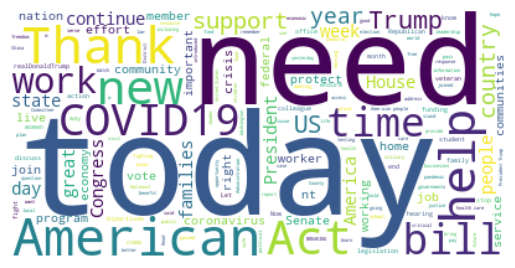

In [11]:
#Lets make a word cloud for each party.

#Democrats Word Cloud

text= ' '.join(congress_tweets['clean_text'].map(lambda text: ' '.join(text)))


# create WordCloud visualization using the "text" object 
wordcloud = WordCloud(background_color = "white",  # set background color to white
                      random_state=41              # set random state to ensure same word cloud each time
                      ).generate(text)             # change the background color


# plot 
plt.imshow(wordcloud,                  # specify wordcloud
           interpolation = 'bilinear') # specifies how the words are displayed
plt.axis('off')                        # turn off axes
plt.show()                             # show the plot



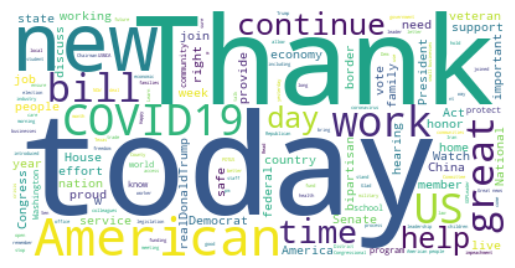

In [12]:
#Republicans Word Cloud
republican_tweets = congress_tweets[congress_tweets['party'] == 'Republican'].copy()

# wordcloud
text_rep= ' '.join(republican_tweets['clean_text'].map(lambda text_rep: ' '.join(text_rep)))


# create WordCloud visualization using the "text" object 
wordcloud = WordCloud(background_color = "white",  # set background color to white
                      random_state=41              # set random state to ensure same word cloud each time
                      ).generate(text_rep)             # change the background color


# plot 
plt.imshow(wordcloud,                  # specify wordcloud
           interpolation = 'bilinear') # specifies how the words are displayed
plt.axis('off')                        # turn off axes
plt.show()                             # show the plot


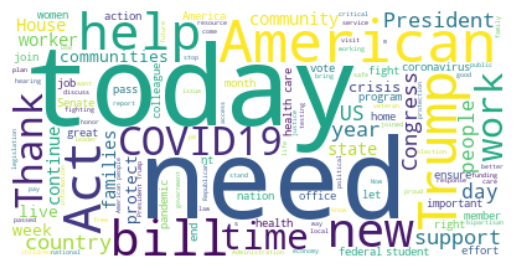

In [13]:
#filter for Republicans
dems_tweets = congress_tweets[congress_tweets['party'] == 'Democrat'].copy()

# wordcloud
text_dems= ' '.join(dems_tweets['clean_text'].map(lambda text_dems: ' '.join(text_dems)))


# create WordCloud visualization using the "text" object 
wordcloud = WordCloud(background_color = "white",  # set background color to white
                      random_state=41              # set random state to ensure same word cloud each time
                      ).generate(text_dems)             # change the background color


# plot 
plt.imshow(wordcloud,                  # specify wordcloud
           interpolation = 'bilinear') # specifies how the words are displayed
plt.axis('off')                        # turn off axes
plt.show()                             # show the plot


### EDA 2

In [14]:
#convert to string 
congress_tweets['clean_text_st'] = congress_tweets['clean_text'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)


In [15]:
congress_tweets.head()

tweet_id   screen_name                   datetime  \
936437  1.187430e+18  RepGwenMoore  2019-10-24T13:57:14-04:00   
101552  1.205240e+18   RepRoKhanna  2019-12-12T16:33:00-05:00   
290630  1.216890e+18   RodneyDavis  2020-01-13T19:52:44-05:00   
280629  1.141100e+18      RepCheri  2019-06-18T18:00:36-04:00   
812427  1.257780e+18  RepPeteOlson  2020-05-05T17:06:55-04:00   

                                                                                                                                                                                                                                                                                                                                                                    text  \
936437  Trump's #gagrule is causing real harm. Not only does this policy jeopardize low-income women’s access to cancer screenings and reproductive care, but the lack of funding could result in higher costs for patients. The ripple effects endanger women. https://www.nbcnews.com/news/latino/nearly-900-women-s-health-clinics-have-lost-federal-funding-n1069591   
101552                                                                          Wondering how we are going to pay for #MedicareForAll? Questions about how to keep your doctor, or what zero copay and zero premiums will mean for you? Join me tomorrow at 10am EST for a livestream with policy experts to discuss what the future of American health care looks like.   
290630                                     According to a 2018 report from the Equal Employment Opportunity Commission (EEOC), “women, especially older women, but also those at middle age, were subjected to more age discrimination than older men.” I offered an amendment to study this impact. https://www.youtube.com/watch?v=CK2d6qfYfAo&feature=youtu.be&t=4608   
280629     Had a great conversation about improving rural health care with @UICnursing in the Quad-Cities yesterday. Bringing down the cost of health care will remain a top priority of mine. Learn more in the @Dispatch_Argus: \n \nhttps://qconline.com/news/local/there-s-a-huge-need-nurses-talk-about-work-in/article_40ee6f12-765f-5686-9a75-5abf893f1560.html#1   
812427                                                                                                              Mental health is extremely important in these challenging times. @NAMIGulfCoast is making sure the people of #BrazoriaCounty know no one is alone. Another terrific example of #TX22GoodWillCreators! http://pbs.twimg.com/media/EXSGVH5WkAAOOgo.jpg   

                                                                                                                                                                                                                      clean_text  \
936437  [Trumps, gagrule, causing, real, harm, Not, policy, jeopardize, lowincome, women, access, cancer, screenings, reproductive, care, lack, funding, result, higher, costs, patients, The, ripple, effects, endanger, women]   
101552                                 [Wondering, going, pay, MedicareForAll, Questions, doctor, copay, premiums, mean, Join, tomorrow, EST, livestream, policy, experts, discuss, future, American, health, care, looks, like]   
290630               [According, report, Equal, Employment, Opportunity, Commission, EEOC, “, women, especially, older, women, middle, age, subjected, age, discrimination, older, men, ”, I, offered, amendment, study, impact]   
280629                                                       [Had, great, conversation, improving, rural, health, care, UICnursing, QuadCities, yesterday, Bringing, cost, health, care, remain, priority, Learn, DispatchArgus]   
812427                                                   [Mental, health, extremely, important, challenging, times, NAMIGulfCoast, making, sure, people, BrazoriaCounty, know, Another, terrific, example, TX22GoodWillCreators]   

       name_wikipedia position joined_congress_date    birthday gen

In [16]:
#Lets do a Scatter Text with subjectivity measures. 

# create measure of subjectivity
# ---------- 
corpus = st.CorpusFromPandas(congress_tweets[:1000],              # specify data
                             category_col = 'party', # specify the explanatory variable  
                             text_col = 'clean_text_st',      # specify the text column
                             nlp = nlp).build()        # apply the nlp algorithim and build



In [17]:
print(len(corpus.get_texts()))
print(len(congress_tweets['screen_name']))

997
2000


In [18]:
# create html document
html = st.produce_scattertext_explorer(corpus,
                                       category='Republican',
                                       category_name='Republican',
                                       not_category_name='Democrat',
                                       width_in_pixels=1000,
                                       minimum_term_frequency=5,
                                     )

In [19]:
# write html document to memory and open in browser
open("Congress_tweets.html", 'wb').write(html.encode('utf-8'))

817487

See output in the repo folder 

## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

In [20]:
#Sentiment polarity 

congress_tweets['polarity'] = congress_tweets['clean_text_st'].map(lambda text: TextBlob(text).sentiment.polarity)

In [21]:
#finding the reps or senators 
unique_categories = congress_tweets['screen_name'].unique()

# Display the unique categories
print(unique_categories)

['RepGwenMoore' 'RepRoKhanna' 'RodneyDavis' 'RepCheri' 'RepPeteOlson'
 'RepHalRogers' 'RepMalinowski' 'RepBillFlores' 'SenKevinCramer'
 'RepTomSuozzi' 'RepRossSpano' 'SenJohnThune' 'EleanorNorton' 'ChrisCoons'
 'RepVeasey' 'RepJoeNeguse' 'RepDavids' 'RepCarbajal' 'SenBlumenthal'
 'RepLloydDoggett' 'RepLaHood' 'LeaderHoyer' 'MarshaBlackburn'
 'SenatorWicker' 'SpeakerPelosi' 'MarkWarner' 'RepDonBeyer'
 'SenatorMenendez' 'PatrickMcHenry' 'RepKendraHorn' 'RepJoeWilson'
 'RepWalorski' 'SenTedCruz' 'JoaquinCastrotx' 'SenWarren' 'RepPerlmutter'
 'CongBoyle' 'GerryConnolly' 'RepRutherfordFL' 'RepJerryNadler'
 'RepLoisFrankel' 'RepMaloney' 'RepBera' 'RepSmucker' 'SenJackyRosen'
 'Sen_JoeManchin' 'RepGraceMeng' 'GOPLeader' 'RepLoriTrahan'
 'RepJohnJoyce' 'RepAngieCraig' 'BillPascrell' 'Rep_Watkins' 'RepEscobar'
 'RepDarrenSoto' 'SenatorBraun' 'SenJohnHoeven' 'SenRubioPress'
 'RepJoseSerrano' 'RepSwalwell' 'RepBeatty' 'SenMcSallyAZ' 'SenatorLeahy'
 'SenBrianSchatz' 'SenatorTester' 'RepJimmyPanett

In [22]:
# I will compare Ted Cruz (R) with Joaquin Castro (D)
castrocruz_tweets = congress_tweets[(congress_tweets['screen_name'] == 'SenTedCruz') | (congress_tweets['screen_name'] == 'JoaquinCastrotx')]

/Users/jama/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


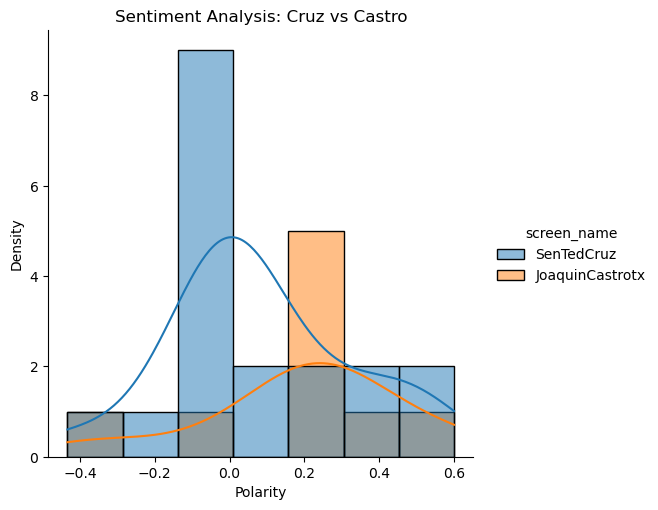

In [23]:
# Plot
sns.displot(data=castrocruz_tweets, x="polarity", hue="screen_name", kde=True, common_norm=False)
plt.title("Sentiment Analysis: Cruz vs Castro")
plt.xlabel("Polarity")
plt.ylabel("Density")
plt.show()

/Users/jama/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


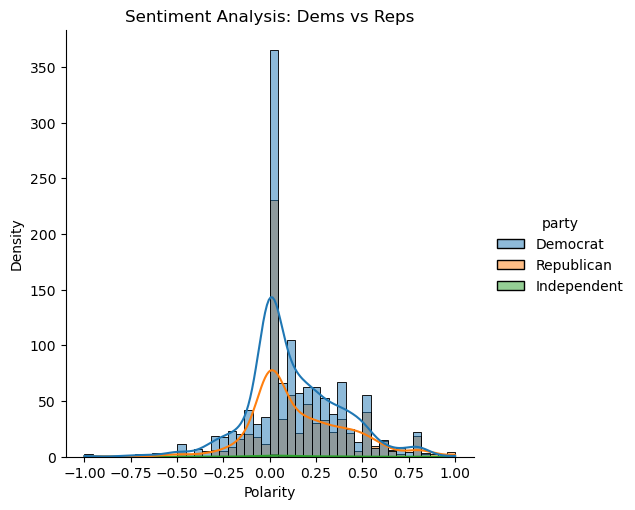

In [24]:
# Plot
sns.displot(data=congress_tweets, x="polarity", hue="party", kde=True, common_norm=False)
plt.title("Sentiment Analysis: Dems vs Reps")
plt.xlabel("Polarity")
plt.ylabel("Density")
plt.show()

/Users/jama/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


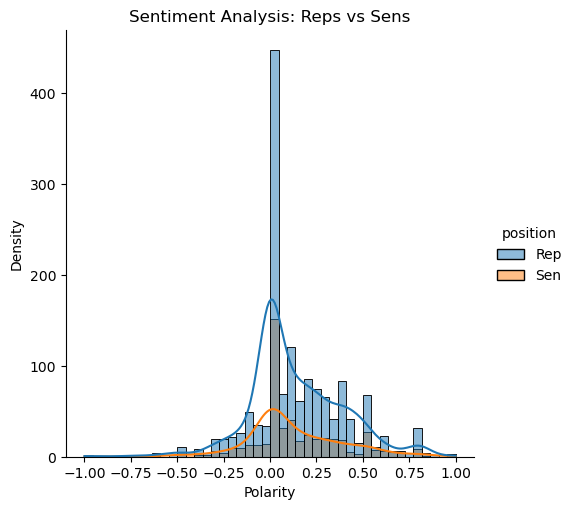

In [25]:
# Plot
sns.displot(data=congress_tweets, x="polarity", hue="position", kde=True)
plt.title("Sentiment Analysis: Reps vs Sens")
plt.xlabel("Polarity")
plt.ylabel("Density")
plt.show()

## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

### Engineered Text Features

In [27]:
# Engineered Features. Length, Word count , subjectivity and polarity. 

# apply length function to tokens column to count each character
congress_tweets['tweet_len'] = congress_tweets['clean_text_st'].apply(len)

# apply length function to tokens column to count words 
congress_tweets['word_count'] = congress_tweets['clean_text_st'].apply(lambda x: len(str(x).split()))

congress_tweets['subjectivity'] = congress_tweets['clean_text_st'].map(lambda x: TextBlob(x).sentiment.subjectivity) # iterate over "x" element


# view the new feature we just created
engineered_features_df = congress_tweets[['tweet_len', 'word_count', 'subjectivity', 'polarity']]
engineered_features_df

tweet_len  word_count  subjectivity  polarity
936437        189          26      0.400000  0.225000
101552        162          22      0.270833 -0.104167
290630        177          25      0.312500  0.125000
280629        144          18      0.375000  0.400000
812427        150          16      0.817778  0.260000
...           ...         ...           ...       ...
198618        193          26      0.572222  0.100000
520865        134          19      0.766667  0.245455
893643        162          21      0.711111  0.116667
675492        209          25      0.819444 -0.125000
858078        199          24      0.179167  0.095833

[2000 rows x 4 columns]

### Bag-of-words or Tf-idf

In [28]:
# Frequency Based featurization. Tf-idf. 

# create tf-idf matrix


# set X dataset
X = congress_tweets['clean_text_st']    

# initialize tf-idf using our preprocessing function
tf = TfidfVectorizer(tokenizer = rem_punc_stop, # use our function for tokenizing created above
                     token_pattern = None)      # set to "None" since we have specify our own pattern

# fit and transform data
tfidf_matrix =  tf.fit_transform(X)

# create dense matrix just to view
dense_matrix = tfidf_matrix.todense()
dense_matrix 

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [29]:


# convert matrix to an arrray and then to a dataframe
tfidf_df = pd.DataFrame(data = tfidf_matrix.toarray(),       # convert to array than to datafram
                         columns=tf.get_feature_names_out()) # specify column names as feature names from TF vectorizer

# sort by term frequency on the first document
tfidf_df.T.nlargest(10,  # transpose the matrix = columns become documents and rows are words
                     0)  # on column index 0 to show the largest

0     1         2     3     4     5     6     7     8     \
women         0.293208   0.0  0.270058   0.0   0.0   0.0   0.0   0.0   0.0   
gagrule       0.250346   0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   
reproductive  0.250346   0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   
ripple        0.250346   0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   
endanger      0.237511   0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   
jeopardize    0.228404   0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   
screenings    0.228404   0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   
higher        0.221340   0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   
lowincome     0.221340   0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   
causing       0.210688   0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   

              9     ...  1990  1991  1992      1993  1994  1995  1996  1997  \
women          0.0  ...   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   
gagrule        0.0  ...   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   
reproductive   0.0  ...   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   
ripple         0.0  ...   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   
endanger       0.0  ...   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   
jeopardize     0.0  ...   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   
screenings     0.0  ...   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   
higher         0.0  ...   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   
lowincome      0.0  ...   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   
causing        0.0  ...   0.0   0.0   0.0  0.198994   0.0   0.0   0.0   0.0   

              1998      1999  
women          0.0  0.151786  
gagrule        0.0  0.000000  
reproductive   0.0  0.000000  
ripple         0.0  0.000000  
endanger       0.0  0.000000  
jeopardize     0.0  0.000000  
screenings     0.0  0.000000  
higher         0.0  0.000000  
lowincome      0.0  0.000000  
causing        0.0  0.000000  

[10 rows x 2000 columns]

### Word Embedding

In [30]:
#Install if necessary 
#!pip install gensim
#!pip install tqdm
#!pip install adjustText


In [31]:
from tqdm import tqdm

import gensim
from gensim import models
from gensim.models import KeyedVectors
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.manifold import TSNE
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score


import multiprocessing

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
# Load Word2Vec model from Google (I'll delete later)

googlenews_word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('/Users/jama/Documents/GitHub/Computational-Social-Science-Projects/Project_5/data/GoogleNews-vectors-negative300.bin', binary = True) 

In [33]:
# average word embeddings for a document
def document_vector(doc):
    doc = [word for word in doc if word in googlenews_word2vec_model.key_to_index] # Remove out-of-vocabulary words
    if not doc:
        return np.zeros(googlenews_word2vec_model.vector_size)
    return np.mean(googlenews_word2vec_model[doc], axis=0)

# Tokenize 
congress_tweets['clean_text_st'] = congress_tweets['clean_text_st'].apply(lambda x: x.split())  # Simple tokenizer

# Apply function 
embedding_features = np.array([document_vector(doc) for doc in congress_tweets['clean_text_st']])

# dataframe
embedding_features_df = pd.DataFrame(embedding_features)


In [34]:
embedding_features_df.head(20)

0         1         2         3         4         5         6    \
0  -0.016810  0.061536 -0.028025  0.102829 -0.057710  0.014792  0.043282   
1  -0.030396  0.073626  0.070863  0.154904  0.010213  0.045718  0.124313   
2  -0.049168 -0.007580 -0.053114  0.002318  0.038479 -0.037308  0.073216   
3  -0.075293  0.100411  0.006022  0.039736  0.027242  0.037854  0.135894   
4   0.008430  0.056291 -0.007756  0.062195 -0.023914  0.061664  0.048227   
5   0.125374 -0.012093 -0.076141  0.110764  0.044342 -0.034672  0.064758   
6   0.001328  0.044883  0.075492  0.036179 -0.041376 -0.015811  0.042726   
7  -0.007468  0.078827  0.054632  0.025882 -0.030269 -0.079102  0.051059   
8  -0.034659  0.051049 -0.060172  0.048319 -0.041364 -0.102202 -0.007169   
9  -0.007496  0.026998  0.070792 -0.036219 -0.105069  0.035278 -0.032903   
10 -0.017792 -0.044294 -0.077619  0.036724  0.101222  0.081855  0.007254   
11 -0.014072  0.103928 -0.031646  0.106699 -0.123344 -0.000828 -0.027676   
12  0.009888  0.046587  0.041281  0.074606 -0.024562 -0.098768 -0.005625   
13  0.007584  0.035046  0.082981  0.140749 -0.107979 -0.001259  0.066574   
14  0.020669  0.039517  0.053303  0.098755 -0.132511 -0.015065  0.087266   
15 -0.005995  0.002890  0.030961  0.025336 -0.084295 -0.098987  0.006095   
16 -0.025635 -0.253906 -0.063477 -0.183594 -0.234375 -0.043213  0.223633   
17  0.030518  0.060539  0.067641  0.075788 -0.114866 -0.077405 -0.002652   
18 -0.036925  0.108914  0.051799  0.101993 -0.065778  0.025481 -0.013265   
19  0.024984  0.033927  0.013908 -0.035073 -0.085213  0.002716  0.015198   

         7         8         9    ...       290       291       292       293  \
0   0.007105  0.071230  0.064136  ... -0.012461  0.051932 -0.079639  0.033440   
1  -0.044831  0.133341 -0.032112  ...  0.036154 -0.001231 -0.067081  0.040443   
2   0.031210  0.055680  0.099742  ... -0.006072  0.000510 -0.043180 -0.074261   
3  -0.017887  0.075960  0.031038  ... -0.093945  0.057874 -0.059468  0.008261   
4   0.021156  0.096878  0.066453  ... -0.032172  0.027433 -0.106154 -0.012634   
5   0.064453  0.050415  0.023315  ... -0.093628  0.007301 -0.095245 -0.107959   
6  -0.057187  0.112015  0.031491  ... -0.083826  0.009991 -0.094325  0.003349   
7  -0.142027  0.146010 -0.015489  ... -0.040789 -0.031880 -0.112455  0.067548   
8   0.030956  0.084759 -0.007254  ... -0.015008 -0.105722 -0.049151  0.038043   
9   0.002666  0.129137  0.001758  ... -0.072550 -0.058207 -0.183196  0.078835   
10 -0.028083  0.016269 -0.017072  ... -0.082646  0.004841 -0.051036 -0.043361   
11 -0.032928  0.039498 -0.024944  ... -0.074121 -0.023945 -0.048092 -0.039125   
12  0.027069  0.065423  0.028003  ... -0.086267 -0.056697 -0.126282  0.030699   
13  0.040039  0.077379 -0.027363  ... -0.037701  0.001480 -0.074219  0.015285   
14 -0.061078  0.040509  0.007683  ... -0.105971 -0.069077 -0.038064 -0.058450   
15  0.071100  0.031780 -0.001374  ... -0.094974 -0.071361 -0.049874 -0.037197   
16 -0.182617  0.119629 -0.279297  ...  0.128906 -0.011597 -0.242188  0.351562   
17  0.015476  0.046319 -0.000187  ... -0.075798  0.027216 -0.046972  0.021353   
18 -0.054403  0.068720  0.022742  ... -0.125106  0.017399 -0.126055  0.012062   
19  0.052139  0.192075  0.023804  ... -0.034542 -0.008781 -0.123984 -0.004069   

         294       295       296       297       298       299  
0  -0.063740  0.033807 -0.047000 -0.040535  0.131507 -0.019648  
1   0.025722 -0.008940  0.015672 -0.058037  0.088097 -0.010893  
2  -0.039402  0.045263 -0.004044 -0.003004  0.050577  0.018255  
3  -0.033551 -0.007918 -0.010881 -0.085492  0.117537 -0.045391  
4  -0.054688 -0.013315 -0.008202  0.015775  0.093889  0.021691  
5   0.053734  0.003052  0.026611  0.005859  0.067780 -0.065002  
6   0.039848 -0.002572 -0.034411 -0.017159  0.077817 -0.014026  
7  -0.156810 -0.054932  0.046232 -0.027223  0.030166  0.046175  
8  -0.003282 -0.095707 -0.099059  0.043783  0.056237  0.002343  
9   0.003371 -0.007960 -0.073458 -0.039974  0.047129 -0.0925

In [35]:
model = gensim.models.Word2Vec(congress_tweets['clean_text'],    # specify data - sentences (interesting why in some I have to change from list to string and viceversa)
                               vector_size=100,   # set embedding size at 100
                               window=5,          # max distance between current and predicted word
                               min_count=5,       # ignores words with freq fewer than this threshold
                               sg=0,              # specify Continuous Bag of Words Algorithim
                               alpha=0.025,       # learning rate
                               epochs = 5,        # iterations
                               seed = 1,          # set random seed (same as random_state in sklearn )
                               batch_words=10000, # sample size 
                               workers = 1)       # set cores to 1 to ensure this embeddings are fully reproducible

In [36]:
def document_vector(word2vec_model, doc):
    # Filter out words that are not present in the vocabulary
    doc = [word for word in doc if word in word2vec_model.key_to_index]
    if doc:  # Check if doc is not empty
        return np.mean(word2vec_model.__getitem__(doc), axis=0)
    else:
        # Return None or any default value if doc is empty
        return np.zeros(word2vec_model.vector_size)  # Return zero vector if doc is empty

In [37]:
# create an array for the size of the corpus
# ----------
# create empty list
empty_list_embeddings_means = []

# loop over each each token
for doc in congress_tweets['clean_text']: # append the vector for each document
    empty_list_embeddings_means.append(document_vector(googlenews_word2vec_model, doc))

# convert the list to array
doc_average_embeddings = np.array(empty_list_embeddings_means) 

# make df of averages
word2vec_features_df = pd.DataFrame(doc_average_embeddings)

In [38]:
word2vec_features_df

0         1         2         3         4         5         6    \
0    -0.016810  0.061536 -0.028025  0.102829 -0.057710  0.014792  0.043282   
1    -0.030396  0.073626  0.070863  0.154904  0.010213  0.045718  0.124313   
2    -0.049168 -0.007580 -0.053114  0.002318  0.038479 -0.037308  0.073216   
3    -0.075293  0.100411  0.006022  0.039736  0.027242  0.037854  0.135894   
4     0.008430  0.056291 -0.007756  0.062195 -0.023914  0.061664  0.048227   
...        ...       ...       ...       ...       ...       ...       ...   
1995 -0.018093  0.052892 -0.010800  0.028692 -0.066772 -0.076154 -0.048122   
1996  0.051344  0.105001 -0.022949  0.169217 -0.077803  0.033013  0.134779   
1997 -0.003097  0.092216 -0.006174  0.100824 -0.064158 -0.043285  0.050980   
1998 -0.054947  0.065233  0.083984  0.038290 -0.037131 -0.085519  0.062093   
1999  0.016609  0.054176  0.043406  0.079206  0.025606 -0.145067 -0.014957   

           7         8         9    ...       290       291       292  \
0     0.007105  0.071230  0.064136  ... -0.012461  0.051932 -0.079639   
1    -0.044831  0.133341 -0.032112  ...  0.036154 -0.001231 -0.067081   
2     0.031210  0.055680  0.099742  ... -0.006072  0.000510 -0.043180   
3    -0.017887  0.075960  0.031038  ... -0.093945  0.057874 -0.059468   
4     0.021156  0.096878  0.066453  ... -0.032172  0.027433 -0.106154   
...        ...       ...       ...  ...       ...       ...       ...   
1995  0.031318  0.094546  0.022583  ... -0.059966  0.047898 -0.132616   
1996 -0.100557  0.145706  0.016461  ...  0.001373 -0.052032 -0.148722   
1997 -0.022469  0.165688  0.064980  ... -0.101845 -0.041266 -0.054366   
1998 -0.046830  0.127783  0.076942  ... -0.060936 -0.010397 -0.087971   
1999 -0.006299  0.035095  0.018508  ... -0.020987 -0.117510 -0.141889   

           293       294       295       296       297       298       299  
0     0.033440 -0.063740  0.033807 -0.047000 -0.040535  0.131507 -0.019648  
1     0.040443  0.025722 -0.008940  0.015672 -0.058037  0.088097 -0.010893  
2    -0.074261 -0.039402  0.045263 -0.004044 -0.003004  0.050577  0.018255  
3     0.008261 -0.033551 -0.007918 -0.010881 -0.085492  0.117537 -0.045391  
4    -0.012634 -0.054688 -0.013315 -0.008202  0.015775  0.093889  0.021691  
...        ...       ...       ...       ...       ...       ...       ...  
1995  0.033107 -0.003127  0.013387  0.018126 -0.051581  0.036598 -0.059280  
1996  0.026123 -0.088443  0.069946 -0.094991  0.040549  0.169444 -0.005985  
1997 -0.013405 -0.047887 -0.032835  0.050657  0.012354  0.065748 -0.044331  
1998  0.035718 -0.054083  0.008983  0.011196 -0.031955  0.135516 -0.015619  
1999 -0.027084 -0.069493  0.006083  0.032514 -0.013794  0.050103  0.010760  

[2000 rows x 300 columns]

In [39]:
words = list(model.wv.index_to_key)
print(words[0:100])  # print the first 100 words


['I', 'The', ' ', 'We', 'Trump', 'This', 'COVID19', 'today', 'need', 'Act', 'American', 'people', 'President', 'help', '“', '”', 'House', 'work', 'It', 'health', 'Americans', 'support', 'bill', 'time', 'US', 'country', 'Congress', '—', 'Thank', 'care', 'continue', 'new', 'families', 'Today', 'communities', 'workers', 'federal', 'Senate', 'America', 'working', 'nt', 'protect', 'community', 'crisis', 'like', 'important', 'realDonaldTrump', 'great', 'He', 'years', 'As', 'week', '–', 'economy', 'nation', 'day', 'public', 'My', 'vote', 'Our', 'bipartisan', 'A', 'In', 'law', 'fight', 'year', 'lives', 'proud', 'home', 'pandemic', 'passed', 'jobs', 'That', 'funding', 'colleagues', 'state', 'right', 'family', '\n ', 'women', 'members', 'businesses', 'stop', 'legislation', 'discuss', 'ensure', 'Democrats', 'safe', 'If', 'hearing', 'news', 'relief', 'join', 'know', 'students', 'w', 'border', 'access', 'Thanks', 's']


In [40]:
#New computer, more power! 
cores = multiprocessing.cpu_count()
cores

11

## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

# Model 1: Party Logit model with engineered features 

In [41]:

# engineered_features_df is your DataFrame with features 
X = engineered_features_df
y = congress_tweets['party'].apply(lambda x: 0 if pd.isna(x) or x != 'Democrat' else 1)

# Initialize a Logistic Regression classifier
log_reg = LogisticRegression(max_iter=1000)

# Define CV settings
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=89)

# Define metrics 
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'f1_score': make_scorer(f1_score)}

cv_results = cross_validate(log_reg, X, y, cv=cv, scoring=scoring)

print(f"Average Accuracy: {np.mean(cv_results['test_accuracy']):.4f}")
print(f"Average Precision: {np.mean(cv_results['test_precision']):.4f}")
print(f"Average Recall: {np.mean(cv_results['test_recall']):.4f}")
print(f"Average F1-Score: {np.mean(cv_results['test_f1_score']):.4f}")


Average Accuracy: 0.6290
Average Precision: 0.6300
Average Recall: 0.9960
Average F1-Score: 0.7718


# Model 2: Position Logit model with engineered features 

In [42]:
# engineered_features_df is your DataFrame with features
X = engineered_features_df
y = congress_tweets['position'].apply(lambda x: 1 if x == 'Rep' else 0)  # Convert position to binary

# Initialize a Logistic Regression classifier
log_reg = LogisticRegression(max_iter=1000)

# Define CV settings
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define metrics to evaluate
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'f1_score': make_scorer(f1_score)}

cv_results = cross_validate(log_reg, X, y, cv=cv, scoring=scoring)

print(f"Average Accuracy: {np.mean(cv_results['test_accuracy']):.4f}")
print(f"Average Precision: {np.mean(cv_results['test_precision']):.4f}")
print(f"Average Recall: {np.mean(cv_results['test_recall']):.4f}")
print(f"Average F1-Score: {np.mean(cv_results['test_f1_score']):.4f}")


Average Accuracy: 0.7520
Average Precision: 0.7520
Average Recall: 1.0000
Average F1-Score: 0.8584


# Model 3: Party logit with Tf-idf

In [43]:


# Tf-idf -- # Democrat vs. Republican 


# tfidf_df is your DataFrame with features 
X = tfidf_df
y = congress_tweets['party'].apply(lambda x: 1 if x == 'Democrat' else 0)  # Convert party to binary

# Initialize a Logistic Regression classifier
log_reg = LogisticRegression(max_iter=1000)

# Define CV settings
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define metrics 
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'f1_score': make_scorer(f1_score)}

cv_results = cross_validate(log_reg, X, y, cv=cv, scoring=scoring)

print(f"Average Accuracy: {np.mean(cv_results['test_accuracy']):.4f}")
print(f"Average Precision: {np.mean(cv_results['test_precision']):.4f}")
print(f"Average Recall: {np.mean(cv_results['test_recall']):.4f}")
print(f"Average F1-Score: {np.mean(cv_results['test_f1_score']):.4f}")


Average Accuracy: 0.6690
Average Precision: 0.6595
Average Recall: 0.9817
Average F1-Score: 0.7889


# Model 4: Position logit model with Tf-idf 

In [44]:
# Senator vs. Congressperson 

# tfidf_df is your DataFrame with features 
X = tfidf_df
y = congress_tweets['position'].apply(lambda x: 1 if x == 'Rep' else 0)  # Convert position to binary

# Initialize a Logistic Regression classifier
log_reg = LogisticRegression(max_iter=1000)

# Define CV settings
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define metrics to evaluate
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'f1_score': make_scorer(f1_score)}

cv_results = cross_validate(log_reg, X, y, cv=cv, scoring=scoring)

print(f"Average Accuracy: {np.mean(cv_results['test_accuracy']):.4f}")
print(f"Average Precision: {np.mean(cv_results['test_precision']):.4f}")
print(f"Average Recall: {np.mean(cv_results['test_recall']):.4f}")
print(f"Average F1-Score: {np.mean(cv_results['test_f1_score']):.4f}")


Average Accuracy: 0.7520
Average Precision: 0.7520
Average Recall: 1.0000
Average F1-Score: 0.8584


# Model 5: Party logit with Word Embedding

In [45]:
# embedding_features_df is your DataFrame with features 
X = embedding_features_df
y = congress_tweets['party'].apply(lambda x: 1 if x == 'Democrat' else 0)  # Convert party to binary

# Initialize a Logistic Regression classifier
log_reg = LogisticRegression(max_iter=1000)

# Define CV settings
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define metrics 
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'f1_score': make_scorer(f1_score)}

cv_results = cross_validate(log_reg, X, y, cv=cv, scoring=scoring)

print(f"Average Accuracy: {np.mean(cv_results['test_accuracy']):.4f}")
print(f"Average Precision: {np.mean(cv_results['test_precision']):.4f}")
print(f"Average Recall: {np.mean(cv_results['test_recall']):.4f}")
print(f"Average F1-Score: {np.mean(cv_results['test_f1_score']):.4f}")


Average Accuracy: 0.6695
Average Precision: 0.6824
Average Recall: 0.8897
Average F1-Score: 0.7723


# Model 6: Position logit with Word Embedding

In [46]:
# embedding_features_df is your DataFrame with features 
X = embedding_features_df
y = congress_tweets['position'].apply(lambda x: 1 if x == 'Rep' else 0)  # Convert position to binary

# Initialize a Logistic Regression classifier
log_reg = LogisticRegression(max_iter=1000)

# Define CV settings
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define metrics to evaluate
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'f1_score': make_scorer(f1_score)}

cv_results = cross_validate(log_reg, X, y, cv=cv, scoring=scoring)

print(f"Average Accuracy: {np.mean(cv_results['test_accuracy']):.4f}")
print(f"Average Precision: {np.mean(cv_results['test_precision']):.4f}")
print(f"Average Recall: {np.mean(cv_results['test_recall']):.4f}")
print(f"Average F1-Score: {np.mean(cv_results['test_f1_score']):.4f}")


Average Accuracy: 0.7515
Average Precision: 0.7557
Average Recall: 0.9894
Average F1-Score: 0.8569


### Two Combined Models

In [47]:
# two models ([best text features + non-text features] * [democrat/republican, senator/representative])
# I will choose information that can help to improve the predictions of democrats or republican
# From the variables: I believe: state, birth date (proxy for age), gender. I selected the previous variables becuase they are general enough to improve the prediction but not blatantly obvious as voting shares, that might render the algorithm less useful. 

# select non-text features
non_text_features = congress_tweets[['birthday', 
                                     'gender', 
                                     'state']]

# get dummies of non-text features
non_text_features_dummies = pd.get_dummies(non_text_features).reset_index(drop = True)
non_text_features_dummies.head()




birthday_1/1/1954  birthday_1/1/1965  birthday_1/1/1974  \
0              False              False              False   
1              False              False              False   
2              False              False              False   
3              False              False              False   
4              False              False              False   

   birthday_1/10/1950  birthday_1/10/1959  birthday_1/11/1960  \
0               False               False               False   
1               False               False               False   
2               False               False               False   
3               False               False               False   
4               False               False               False   

   birthday_1/12/1950  birthday_1/13/1971  birthday_1/14/1962  \
0               False               False               False   
1               False               False               False   
2               False               False               False   
3               False               False               False   
4               False               False               False   

   birthday_1/16/1962  ...  state_SD  state_TN  state_TX  state_UT  state_VA  \
0               False  ...     False     False     False     False     False   
1               False  ...     False     False     False     False     False   
2               False  ...     False     False     False     False     False   
3               False  ...     False     False     False     False     False   
4               False  ...     False     False      True     False     False   

   state_VT  state_WA  state_WI  state_WV  state_WY  
0     False     False      True     False     False  
1     False     False     False     False     False  
2     False     False     False     False     False  
3     False     False     False     False     False  
4     False     False     False     False     False  

[5 rows x 462 columns]

In [48]:
# Based on my previous results: The Tf-idf model for predicting party affiliation was better in terms of the F-1 statistic, but slightly worse than the word embedding one in terms of the accuracy.
# I will try to improve the Tf-idf by including the non-text features. 

#Adding non.text features to the tf-idf set 
non_text_plus_tfidf = non_text_features_dummies.reset_index(drop = True).join(tfidf_df)
non_text_plus_tfidf.head()





birthday_1/1/1954  birthday_1/1/1965  birthday_1/1/1974  \
0              False              False              False   
1              False              False              False   
2              False              False              False   
3              False              False              False   
4              False              False              False   

   birthday_1/10/1950  birthday_1/10/1959  birthday_1/11/1960  \
0               False               False               False   
1               False               False               False   
2               False               False               False   
3               False               False               False   
4               False               False               False   

   birthday_1/12/1950  birthday_1/13/1971  birthday_1/14/1962  \
0               False               False               False   
1               False               False               False   
2               False               False               False   
3               False               False               False   
4               False               False               False   

   birthday_1/16/1962  ...    ⊂    ⏰    ⏳    🤒    🤔    🤖    🤝    🤦    🥂    🥛  
0               False  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1               False  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2               False  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3               False  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4               False  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 10850 columns]

In [49]:
# Non-text features only 
X_non_text = non_text_features_dummies  # DataFrame with non-text features
y_party = congress_tweets['party'].apply(lambda x: 1 if x == 'Republican' else 0)  # Binary target

# Initialize Logistic Regression classifier
log_reg_non_text = LogisticRegression(max_iter=1000)

# Cross-validation settings
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Metrics to evaluate
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'f1_score': make_scorer(f1_score)}

# Perform CV
cv_results_non_text = cross_validate(log_reg_non_text, X_non_text, y_party, cv=cv, scoring=scoring)

# Print
print(f"Average Accuracy: {np.mean(cv_results_non_text['test_accuracy']):.4f}")
print(f"Average Precision: {np.mean(cv_results_non_text['test_precision']):.4f}")
print(f"Average Recall: {np.mean(cv_results_non_text['test_recall']):.4f}")
print(f"Average F1-Score: {np.mean(cv_results_non_text['test_f1_score']):.4f}")


Average Accuracy: 0.9615
Average Precision: 0.9671
Average Recall: 0.9263
Average F1-Score: 0.9461


The results are quite good to start with. 

In [50]:
#combined model 

X_combined = non_text_plus_tfidf  # DataFrame with combined text and non-text features
# already defined y above

# Initialize Logistic Regression classifier
log_reg_combined = LogisticRegression(max_iter=1000)

cv_results_combined = cross_validate(log_reg_combined, X_combined, y_party, cv=cv, scoring=scoring)

print(f"Average Accuracy: {np.mean(cv_results_combined['test_accuracy']):.4f}")
print(f"Average Precision: {np.mean(cv_results_combined['test_precision']):.4f}")
print(f"Average Recall: {np.mean(cv_results_combined['test_recall']):.4f}")
print(f"Average F1-Score: {np.mean(cv_results_combined['test_f1_score']):.4f}")




Average Accuracy: 0.9515
Average Precision: 0.9504
Average Recall: 0.9153
Average F1-Score: 0.9324


## Considerable improvements in accuracy and in F1 Score! 
Nonetheless, it is curious to see performance get worse when adding the text features to the non-text ones. Seems like other variables alone are more helpful to help predict, my guess is that state is very specific and autocorrelated. 

## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

**YOUR ANSWER HERE** 

Different bodies text bodies will have characters, expressions, or language uses that might not be considered in previously trained corpi using general texts. In our example, tweets have different information in code, even corresponding to emojis, or bolding characters. Some are shortenings of words, or specific symbols like hashtags. I can think of examples as French speakers that differ from Quebec, Paris, and souther France, as well as Spanish from different countries, or within regions of each country. 

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

**YOUR ANSWER HERE** 
Not really, it looks like the distributions are very similar between parties. There is a high concentration on the 0, meaning a lot of neutral, informative tweets. There seems to be a difference in the slope in the positive, but is minimal. I guess it depends a lot on what political events, where happening on how they were spinning them. 

Comparing individual cases those raises some distinctions but that is because I selected two figures that are outspoken and one republican that is a polemist, so they might not be representative. 

Finally, with Senators I identify a flattened curve, more dispersed which means that they take positive or negative positions that are more clear and distinguishable than representatives. Again is hard to tell what is driving the distribution, maybe its because there is less of them, more seniority and less use of twitter. It could also be that they don't need to face elections constantly, thus can take sides or be more outspoken, or maybe they share less neutral information becuasue they are not as close to their constituents as representatives. 


3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

**YOUR ANSWER HERE** 

Unsupervised learning approaches can give results that are not contextualy relevant, that lack some inputs that can help them improve and adapt. The use of supervised learning can help to address those issues. The combination of both methods  can help to address features selection. 

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

**YOUR ANSWER HERE**

Interestingly, non-text only features only with 3 variables were powerful enough to predict the party affiliation of a tweet in a more efficient way than with the combined model. I think including more non-text information would have actually had better performance. This is surprising because one might think that adding more information about the content of the text would improve, but as seen in the graphs, the distributino of sentiments is not that different so it seems in this sample of tweets, we gain nothing by adding sentiments. We should try other measures as similarity to see if this holds true. Also a bigger sample might have slightly different results, as 1000 might be too small. 

Combining the information can help us include ques that combined should be better at predicting, for example by including the tenure or the state you already have a lot of information, but in narrow cases the polarity might be the one helping to better identify. Non-text features help us with the context, if you think of how humans read, contextual information plays a big role in understanding what we are reading. 


## Part 9 

In [51]:
# Using LLM 

In [52]:
#!pip install transformers

In [53]:
from transformers import pipeline, set_seed

generator = pipeline('text-generation', model='gpt2') 

set_seed(29)
# my text input
input_text = "Can we predict party affiliation from politicians' tweets?"
#input_ids = tokenizer.encode(input_text, return_tensors='pt')

output = generator(input_text, max_length=70, num_return_sequences=5) 
for result in output:
    print(result['generated_text'])
    print("----")
    
    
# Generate text
#text_generator = pipeline('text-generation', model=model, tokenizer=tokenizer)
#generated_text = text_generator(input_text, max_length=50, num_return_sequences=5)

#print(generated_text[0]['generated_text'])


All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Can we predict party affiliation from politicians' tweets? A big question of this magnitude, and it should be part of our election strategy. All candidates should be prepared to do well in their respective party primaries. Our system has been the standard for more than a century; what's important is to keep it accurate, and to be able to match candidates'
----
Can we predict party affiliation from politicians' tweets?

I don't want to waste political capital but maybe we've shown a willingness to use our electoral prowess to win?

Is there a way you could use data to determine the outcome of a race for a city seat?

In the Senate, you could look at the results of
----
Can we predict party affiliation from politicians' tweets? pic.twitter.com/RXwEU9xYxgF — Donald J. Trump (@realDonaldTrump) December 6, 2017

So what has Donald Trump been up to lately?

While no exact statistics have yet been announced to establish how likely that is, it's
----
Can we predict party affiliation from polit

## Well this is fun, but not useful at all! 